# Rapport de projet final: Débordement d'égouts
## Équipe 9 - A19
#### _Noboru Yoshida - Mehdi Chaid - Mathieu Giroux-Huppé - Maxime Gosselin_
<br>
20 Décembre 2019

## Table des matières

+ [1. Introduction](#1.)
    + [1.1. Objectifs](#1.1.)  
    + [1.2. Méthode de travail](#1.2.)  
<br>
+ [2. Analyse exploratoire](#2.)
    + [2.1. Motivation](#2.1.)  
    + [2.2. Importation des données](#2.2.)  
    + [2.3. Fonctions utilisées](#2.3.)
    + [2.4. Analyse des données d'ouvrages](#2.4.)  
        + [2.4.1. Données discrètes](#2.4.1.)
        + [2.4.2. Données de Trop-Plein](#2.4.2.)
        + [2.4.3. Données d'Emissaire](#2.4.3.)
    + [2.5. Analyse des données de précipitations](#2.5.)  
    + [2.6. Analyse des données de surverses](#2.6.)  
    + [2.7. Isolation des ouvrages d'intérêts](#2.7.)
<br>
+ [3. Traitement des données](#3.)
    + [3.1. Motivation](#3.1.)  
    + [3.2. Fonctions utilisées](#2.2.)  
    + [3.3. Ajout de variables explicatives](#3.3.)
    + [3.4. Standardisation et OneHot](#3.4.)  
    + [3.5. Séparation en ensembles de tests et validation](#3.5.)  
    + [3.6. Isolation des ouvrages d'intérêts](#3.6.)
<br>


+ [4. Sélection de modèles](#4.)
    + [4.1. Motivation](#4.1)
    + [4.2. Choix des modèles](#4.2.)
        + [4.2.1. Arbres de décisions](#4.2.1.)
        + [4.2.2. Régression logistique](#4.2.2.)
        + [4.2.3. Classification bayésienne naive](#4.2.3.)
    + [4.3. Arbres de décision et forêt aléatoire](#4.3.)  
    + [4.4. Régression logistique](#4.4.)  
    + [4.5. Classification bayésienne naive](#4.5.)  
    + [4.6. Ensemble de modèles](#4.6.)  
<br>
+ [5. Retour et conclusion](#5.)
    + [5.1. Retour sur les résultats](#5.1.)  
    + [5.2. Améliorations possibles](#5.2.)
    + [5.3. Difficultés rencontrées](#5.3.)
        + [5.3.1. Interpretation des données](#5.3.1.)
    + [5.4. Retour sur le travail en équipe](#5.4.)  
    + [5.5. Conclusion](#5.5.)  
<br>

+ [6. Références](#refs)

<a id="1."></a>

## 1. Introduction

<a id="1.1."></a>
### 1.1. Objectifs

Ce rapport vise à fournir une prédiction sur les surverses dans plusieurs ouvrages sur l'île de Montréal. Il en existe 170 répartis sur tout le bord de l'île. Dans ce travail, nous nous attarderons sur la prédiction de seulement 5 d'entre-eux, soit les suivants :
- 3260-01D dans Rivière-des-Prairies
- 3350-07D dans Ahunstic
- 4240-01D dans Pointe-aux-Trembles
- 4350-01D dans le Vieux-Montréal
- 4380-01D dans Verdun

Nous avons à notre disposition 3 jeux de données qui nous aiderons à trouver une relation entre la quantité de pluie tombé et les surverses de certain ouvrages. Nous devrons alors entraîner un modèle sur les données de 2013 à 2018, puis prédire sur certaines dates de 2019. Il n'y pas de restrictions au niveau des techniques à utilisés pour le type de modèle à utiliser. Nous avons exploré quelques techniques différentes que nous allons détaillé plus en détail dans la [section 5](#model-selection).

<a id="1.2."></a>
### 1.2. Méthode de travail

La méthode de travail employée par notre équipe fut d'abord de mettre tout le monde sur une exploration initiale des données, afin de comprendre en équipe la signification générale de chaque variable explicative fournie, puis d'effectuer une séparation des tâches. L'exploration des données en équipe a aussi été utile pour déterminer les modèles qui nous semblaient les plus intéressants et appropriés selon le contexte.

<br>
Par la suite, une personne était en charge d'effectuer une exploration plus poussée des données tandis que chaque autre membre de l'équipe travaillait sur l'analyse puis l'application d'un modèle différent. Étant 4 membres dans l'équipe, et ayant repéré 3 modèles intéressants, cette séparation fut facile à faire et nous arrangeait.

<br>

Enfin, une fois que nous avions obtenu un prototype fonctionnel pour chacun des modèles, nous nous réunissions en équipe afin d'analyser les résultats et d'améliorer les modèles.

<a id="2."></a>
## 2. Analyse exploratoire

<a id="2.1."></a>
### 2.1. Motivation

L'analyse exploratoire est une très importante pour tout exercice en sciences de données. Elle permet de déterminer, entres autres:

- Quelles variables vont jouer un rôle important pour la prédiction.
- À quel point les variables sont corrélées entre elles.
- Si une régularisation est nécessaire pour certaines variables.
- Comment améliorer le temps d'entrainement et les prédictions.

Pour ce faire, nous allons analyser chacune des variables explicatives en utilisant des graphes et des statistiques afin d'appuyer nos résultats et de guider notre prise de décision.

<a id="2.2."></a>
### 2.2. Importation des données

Installons d'abord les libraires utilisées pour l'analyse exploratoire.

In [ ]:
using Pkg;
Pkg.add("CSV");
Pkg.add("Random");
Pkg.add("DataStructures");
Pkg.add("BenchmarkTools");
Pkg.add("DataFrames");
Pkg.add("Statistics");
Pkg.add("Dates");
Pkg.add("Gadfly");
Pkg.add("IterTools");

Importons maintenant ces données dans le rapport.

In [3]:
using CSV, DataFrames, DataStructures, BenchmarkTools, Statistics, Dates, Gadfly, Random, IterTools;

Configuration de l'outil de visualisation.

In [42]:
set_default_plot_size(25cm, 13cm)

<a id="2.3."></a>
### 2.3. Fonctions utilisées

Nous définissons ici les fonctions utilisées pour l'analyse exploratoire de données.

<a id="2.3.1."></a>
#### 2.3.1. random_first

Cette function est un remplacement à la fonction first qui nous permet d'obtenir un échantillon aléatoire de données.

In [16]:
function random_first(df::DataFrame, nb::Int64, fts::Array=[])
    if length(fts) == 0
        first(df[shuffle(1:size(df, 1)),:], nb)
    else
        first(df[shuffle(1:size(df, 1)),fts], nb)
    end
end

random_first (generic function with 3 methods)

<a id="2.4."></a>
### 2.4. Analyse des données d'ouvrages

Commençons par importer le fichier de données d'ouvrages et renommons les colonnes pour qu'elles soient plus facile à traiter. Le fichier concerné est _ouvrages-surverses.csv_. Pour plus d'informations sur ce jeu de données: http://donnees.ville.montreal.qc.ca/dataset/ouvrage-surverse.

In [32]:
ouvrages = CSV.read("data/ouvrages-surverses.csv");
colnames = ["N_ENV", "ID_SOMA", "ID_OUVRAGE", "NOM", "SOMA_SEC", "REGION", "TP_X", "TP_Y", "TP_Z", "TP_LAT", "TP_LNG", "EMI_X", "EMI_Y", "EMI_LNG", "EMI_LAT"];
names!(ouvrages, Symbol.(colnames));

<a id="2.4.1."></a>
#### 2.4.1. Données discrètes

Tout d'abord, procédons à une analyse des données discrètes des ouvrages. Les données discrètes de ce jeu de données sont:

- N_ENV: Identifiant de l'ouvrage Environnement Canada.
- ID_SOMA: Identifiant de l'ouvrage selon SOMAEU (Gouvernement du Québec).
- ID_OUVRAGE: Identifiant de l'ouvrage selon la ville.
- NOM: Nom de l'ouvrage.
- SOMA_SEC: Nom du secteur SOMAEU où se trouve l'ouvrage.
- REGION: Nom de la région (arrondissement ou municipalité) où se trouve l'ouvrage.

Analysons brièvement chacune de ces variables afin de déterminer si elles pourraient jouer le rôle de variable explicative dans notre situation.

*N_ENV, ID_SOMA, ID_OUVRAGE, NOM:*

In [33]:
random_first(ouvrages, 10, [:N_ENV, :ID_SOMA, :ID_OUVRAGE, :NOM])

,N_ENV,ID_SOMA,ID_OUVRAGE,NOM
,String⍰,String,String,String
1,MTL-65,MTL-63,3530-01D,3530-01D S.P. Marcellin
2,MTL-25,MTL-122,4430-01D,4430-01D Ouv. de regulation Alepin
3,MTL-41,MTL-117,4400-02D,4400-02D Trop-plein Beatty/Av. Verdun
4,MTL-38,MTL-121,4420-04D,4420-04D Trop-plein Richard/Boul. Lasalle
5,MTL-35,MTL-119,4420-02D,4420-02D Deriv. Stephens I
6,MTL-150,MTL-6,3240-01D,3240-01D S.P. 71e avenue - T.-P. d'urgence
7,MTL-53,MTL-64,3540-01D,3540-01D Deriv. St-Martin
8,MTL-91,MTL-41,3350-08D,3350-08D Trop-plein Bohle
9,MTL-157,MTL-5,3230-01D,3230-01D Ouv. de regul. St-Jean-Baptiste Nord (RdP)


Comme on peut le voir, chaque ouvrage possède une valeur unique pour ces colonnes. Celà fait du sens, compte tenu qu'il s'agit d'un identifiant unique à l'ouvrage, exprimé sous plusieurs normes.
<br>

En raison du faible pouvoir prédictif d'une telle propriété, dûe à l'unicité de chaque valeur, et de la haute corrélation entre les variables, nous avons décidé de ne pas inclure ces variables dans notre modèle. Nous conservons évidemment l'identifiant de l'ouvrage (_ID_OUVRAGE_) qui va permettre d'identifier chaque ouvrage et de joindre plusieurs jeux de données ensemble, mais les autres ne semblent pas posséder de pouvoir prédictif significatif.
<br>

Il est à noter que le numéro contenu dans _N_ENV_ et _ID_SOMA_, ainsi que les 3 lettres dans _ID_SOMA_ pourraient tous deux permettrent de grouper certains ouvrages ensembles ou de les localiser dans une carte, mais d'autres variables explicatives abordées à la section [2.4.1. Données discrètes](#2.4.1.) et [2.4.2. Données de Trop-Plein](#2.4.2.) s'occupent déjà de cette localisation. 

_SOMA_SEC, REGION_

Observons maintenant les effets de ces deux variables discrètes. Tout d'abord, le secteur selon la norme SOMAEU. Visualisons la carte de Montréal selon les positions de Trop-Pleins, identifiant le secteur SOMAEU par couleur.

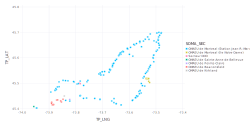

In [41]:
plot(ouvrages,x=:TP_LNG, y=:TP_LAT, Geom.point, color= :SOMA_SEC)

Comme on peut le voir, la majorité des ouvrages sont groupés sous le secteur _OMAEU de Montreal (Station Jean-R.-Marcotte_). Ce problème d'imbalancement de classes pourrait s'avérer problématique. Effectuons maintenant la même tâche pour la séparation de secteurs selon leur arrondissement ou municipalité.

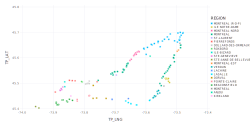

In [43]:
plot(ouvrages,x=:TP_LNG, y=:TP_LAT, Geom.point, color= :REGION)

Les secteurs sont beaucoups mieux balancés. Cette variable explicative permet de grouper ensemble un certain nombres d'ouvrages, ce qui pourrait s'avérer utile pour la prédiction.

On remarque cependant que certaines régions ne contiennent que très peu d'ouvrages. Il pourrait être intéressant de grouper ensemble des régions contigues afin d'obtenir un nombre d'ouvrage par région plus balancé encore.

<a id="2.4.2."></a>
#### 2.4.2. Données de trop-plein

Passons maintenant à l'analyse des données de trop-plein. Nous avons ici 5 variables explicatives pour le trop-plein.

- TP_X: Coordonnée en X selon la norme NAD83 MTM8.
- TP_Y: Coordonnée en Y selon la norme NAD83 MTM8
- TP_Z: Coordonnée en Z selon la norme NAD83 MTM8.
- TP_LNG: Longitude selon la norme WGS84.
- TP_LAT: Latitude selon la norme WGS84.

Pour ce qui est de l'interprétation des trops-pleins, bien que nous ayons eu certaines difficultés à correctement interpréter le sens de ce terme en comparaison avec les émissaires, comme discuté dans la section [5.3. Difficultés rencontrées](#5.3.), des recherches plus poussées en ligne nous ont guidé vers le sens du trop-plein dans ce contexte: Il s'agit ici de l'ouvrage qui permet aux eaux non dirigées vers la station d'épuration d'être évacuées vers le milieu récepteur naturel<sup>[[1]](#refs)</sup>. 

Les couples de coordonnées [X, Y] et [LNG, LAT] semblent redondantes, testons cette hypothèse.

*TP_X, TP_Y, TP_LNG, TP_LAT:*

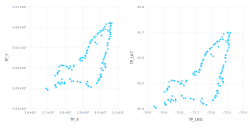

In [45]:
plt_x_y = plot(ouvrages, x=:TP_X, y=:TP_Y, Geom.point);
plt_lng_lat = plot(ouvrages, x=:TP_LNG, y=:TP_LAT, Geom.point);
hstack(plt_x_y, plt_lng_lat)

Comme on peut le voir sur les graphiques, ces données sont en effet plutôt similaires et mappent toutes les deux le contour de l'Ile de Montréal, où sont situés les Trop-Pleins. Nous avons choisi de ne garder pour l'instant que les latitudes et longitudes, ce format étant consistent avec les données présentes dans un autre jeu de données.

*TP_Z:*

Observons maintenant la répartition des hauteurs de trop-plein.

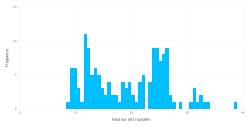

In [47]:
plot(ouvrages, x=:TP_Z, Geom.histogram(bincount=50), Guide.xlabel("Hauteur de trop-plein"),Guide.ylabel("Frequence"))

Une analyse sur les données de hauteur nous informent que cette information est manquante pour une partie des ouvrages. 

In [48]:
describe(ouvrages[!, :TP_Z])

Summary Stats:
Length:         167
Missing Count:  17
Mean:           19.352567
Minimum:        8.347000
1st Quartile:   12.647500
Median:         19.470000
3rd Quartile:   24.902500
Maximum:        38.930000
Type:           Union{Missing, Float64}


Comme on peut le voir, environ 10% des données sont manquantes. Une solution à ce problème est proposée dans la section [3. Traitement des données](#3.).

<a id="2.4.3."></a>
#### 2.4.3. Données d'emissaire

Concluons l'analyse des données d'ouvrages avec les variables concernant l'émissaire. Selon la description des données accompagnant le jeu de données sur le site de Montréal, le positionnement géographique des ouvrages de débordement est associé aux émissaires dans cet ensemble de données<sup>[[2]](#refs)</sup>. 

<a id="5."></a>
## 5. Retour et conclusion

<a id="5.3."></a>
### 5.3. Difficultés rencontrées

Lors de cet exercice, nous avons rencontré un certain nombre de difficultés qui nous en ralentit dans la réalisation du projet. Nous allons discuter ici de ces difficultés.

<a id="5.3.1."></a>
#### 5.3.1. Interprétation des données

Une des plus grande difficultés de ce projet fut de correctement interpréter les données. En effet, une erreur de notre part fut de confondre la signification d'émissaire et de trop-plein. Ne sachant pas initialement ce que ces termes représentaient, une recherche Google Image nous a mené à penser que le trop-plein était une sorte de conteneur dans lequel l'eau s'accumulait et l'émissaire comme étant le tuyeau de déversement vers le fleuve. 
<br>

Cela nous a ainsi mené à effectuer des suppositions qui s'avéraient erronées et ont faussé nos résultats pendant une bonne partie de l'exercice.

<a id="refs"></a>
## 6. Références

## TODO: Référence style APA ou IEEE
+ [1]: http://collections.banq.qc.ca/ark:/52327/bs44911